<a href="https://colab.research.google.com/github/gcheoyh/toy-transfer-learning-eg/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train MNIST Classifier

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model, optimizers, losses, Input
from tensorflow.keras.backend import clear_session
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists, dirname, join
import cv2

In [2]:
mnist_train, mnist_test = tfds.load('mnist', split=['train', 'test'], shuffle_files=False, as_supervised=True)

# convert to numpy format
mnist_x_train = np.stack(list(map(lambda x: x[0].numpy(), mnist_train)), axis=0)
mnist_y_train = np.stack(list(map(lambda x: x[1].numpy(), mnist_train)), axis=0)

mnist_x_test = np.stack(list(map(lambda x: x[0].numpy(), mnist_test)), axis=0)
mnist_y_test = np.stack(list(map(lambda x: x[1].numpy(), mnist_test)), axis=0)


In [3]:
# train-val-test split
train_size = int(mnist_x_train.shape[0] * 0.8)
mnist_x_val = mnist_x_train[train_size:, :, :, :]
mnist_y_val = mnist_y_train[train_size:]
mnist_x_train = mnist_x_train[:train_size, :, :, :]
mnist_y_train = mnist_y_train[:train_size]


mnist_x_train: (48000, 28, 28, 1), mnist_x_val: (12000, 28, 28, 1), mnist_x_test: (10000, 28, 28, 1)
mnist_y_train: (48000,), mnist_y_val: (12000,), mnist_y_test: (10000,)


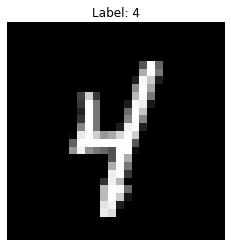

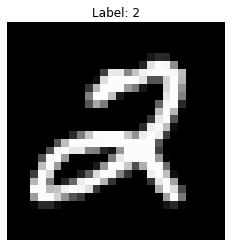

In [4]:
# check data
print(f'mnist_x_train: {mnist_x_train.shape}, mnist_x_val: {mnist_x_val.shape}, mnist_x_test: {mnist_x_test.shape}')
print(f'mnist_y_train: {mnist_y_train.shape}, mnist_y_val: {mnist_y_val.shape}, mnist_y_test: {mnist_y_test.shape}')

# display single image from x_train and x_test
plt.figure()
plt.imshow(mnist_x_train[0, :, :, :].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title(f'Label: {mnist_y_train[0]}')
plt.show()

plt.figure()
plt.imshow(mnist_x_test[0, :, :, :].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title(f'Label: {mnist_y_test[0]}')
plt.show()

In [5]:
# simple model
cnn = models.Sequential()
cnn.add(layers.Conv2D(filters=32, kernel_size=3, input_shape=(28, 28, 1))) # conv first layer
cnn.add(layers.BatchNormalization())
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Conv2D(filters=64, kernel_size=3, input_shape=(28, 28, 1))) # conv first layer
cnn.add(layers.BatchNormalization())
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(1024, activation='relu'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Dropout(0.3))
cnn.add(layers.Dense(256, activation='relu'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Dropout(0.3))
cnn.add(layers.Dense(10, activation='softmax'))

print(cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

In [6]:
# compile model
opt = optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)
loss = losses.SparseCategoricalCrossentropy(from_logits=False) # using softmax layer
cnn.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [7]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# change directory
% cd /content/drive/MyDrive/Colab\ Notebooks/misc/toy-transfer-learning-eg
! pwd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/misc/toy-transfer-learning-eg
/content/drive/MyDrive/Colab Notebooks/misc/toy-transfer-learning-eg


In [8]:
MNIST_MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/misc/toy-transfer-learning-eg/mnist_classifier.h5'

if exists(MNIST_MODEL_PATH):
    # load model if possible
    cnn = models.load_model(MNIST_MODEL_PATH)

else:

    # train model with early stopping on val loss
    print('Training model')
    callback = EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=True)
    hist = cnn.fit(mnist_x_train, mnist_y_train, batch_size=32, epochs=30,
                   validation_data = (mnist_x_val, mnist_y_val), callbacks=[callback])
    
    # save model
    cnn.save(MNIST_MODEL_PATH)

# test on test set to make sure it works
print('\nTesting model')
results = cnn.evaluate(mnist_x_test, mnist_y_test, batch_size=128)
print(f'Test loss: {results[0]:.4f}, test acc: {results[1]:.4f}')




Testing model
79/79 [==============================] - 2s 3ms/step - loss: 0.0330 - accuracy: 0.9902
Test loss: 0.0330, test acc: 0.9902


# Retrieve EMNIST Letters Dataset and Perform Transfer Learning

In [9]:
letters_train, letters_test = tfds.load('emnist/letters', split=['train', 'test'], shuffle_files=False, as_supervised=True)

In [10]:
# convert to numpy format
letters_x_train = np.stack(list(map(lambda x: x[0].numpy().T.reshape(28, 28, 1), letters_train)), axis=0)
letters_y_train = np.stack(list(map(lambda x: x[1].numpy(), letters_train)), axis=0)
letters_y_train -= 1  # zero index the labels

# artificially limit size of training set to show benefits of fine tuning
max_size = 5000
letters_x_train = letters_x_train[:max_size, :]
letters_y_train = letters_y_train[:max_size]

letters_x_test = np.stack(list(map(lambda x: x[0].numpy().T.reshape(28, 28, 1), letters_test)), axis=0)
letters_y_test = np.stack(list(map(lambda x: x[1].numpy(), letters_test)), axis=0)
letters_y_test -= 1  # zero index the labels


In [11]:
# train test split for letters
train_size = int(letters_x_train.shape[0] * 0.8)
letters_x_val = letters_x_train[train_size:, :]
letters_y_val = letters_y_train[train_size:]

letters_x_train = letters_x_train[:train_size, :] 
letters_y_train = letters_y_train[:train_size]

letters_x_train: (4000, 28, 28, 1), letters_x_val: (1000, 28, 28, 1), letters_x_test: (14800, 28, 28, 1)
letters_y_train: (4000,), letters_y_val: (1000,), letters_y_test: (14800,)


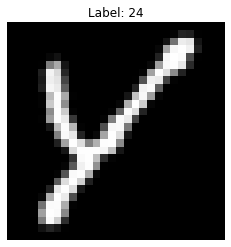

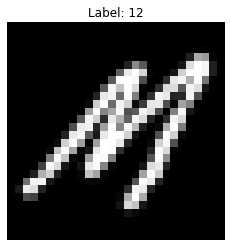

In [12]:
# check data
print(f'letters_x_train: {letters_x_train.shape}, letters_x_val: {letters_x_val.shape}, letters_x_test: {letters_x_test.shape}')
print(f'letters_y_train: {letters_y_train.shape}, letters_y_val: {letters_y_val.shape}, letters_y_test: {letters_y_test.shape}')

# display single image from x_train and x_test
plt.figure()
plt.imshow(letters_x_train[0, :, :, :].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title(f'Label: {letters_y_train[0]}')
plt.show()

plt.figure()
plt.imshow(letters_x_test[0, :, :, :].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title(f'Label: {letters_y_test[0]}')
plt.show()

In [13]:
letters_cnn = models.Sequential(cnn.layers[:-1])
letters_cnn.add(layers.Dense(26, activation='softmax')) # add new softmax layer
print(letters_cnn.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)             

In [14]:
# freeze convolutional layers
# not advisable to freeze batch normalization due to different batch statistics (different domain)
# https://forums.fast.ai/t/why-are-batchnorm-layers-set-to-trainable-in-a-frozen-model/46560
for layer in letters_cnn.layers:
    name = layer.name
    if 'conv2d' in name:
        layer.trainable = False

for layer in letters_cnn.layers:
    print(f'Name:{layer.name}, trainable status:{layer.trainable}')

# compile model
letters_cnn.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

Name:conv2d_4, trainable status:False
Name:batch_normalization_7, trainable status:True
Name:max_pooling2d_4, trainable status:True
Name:conv2d_5, trainable status:False
Name:batch_normalization_8, trainable status:True
Name:max_pooling2d_5, trainable status:True
Name:flatten_2, trainable status:True
Name:dense_6, trainable status:True
Name:batch_normalization_9, trainable status:True
Name:dropout_3, trainable status:True
Name:dense_7, trainable status:True
Name:batch_normalization_10, trainable status:True
Name:dropout_4, trainable status:True
Name:dense_3, trainable status:True


In [15]:
# finetune network!
print('Finetuning letters model')
callback = EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=True)
letters_hist = letters_cnn.fit(letters_x_train, letters_y_train, batch_size=32, epochs=30,
                       validation_data = (letters_x_val, letters_y_val), callbacks=[callback])

# save model
# LETTERS_MODEL_PATH = join(dirname(MNIST_MODEL_PATH), 'letters_classifier.h5')
# letters_cnn.save(LETTERS_MODEL_PATH)

# test on test set to make sure it works
print('\nTesting letters model')
results = letters_cnn.evaluate(letters_x_test, letters_y_test, batch_size=128)
print(f'Test loss: {results[0]:.4f}, test acc: {results[1]:.4f}')



Finetuning letters model
Epoch 1/30
125/125 [==============================] - 2s 8ms/step - loss: 3.2922 - accuracy: 0.1772 - val_loss: 1.1857 - val_accuracy: 0.6740
Epoch 2/30
125/125 [==============================] - 1s 4ms/step - loss: 1.3393 - accuracy: 0.6088 - val_loss: 0.7972 - val_accuracy: 0.7700
Epoch 3/30
125/125 [==============================] - 1s 4ms/step - loss: 0.9546 - accuracy: 0.7163 - val_loss: 0.6730 - val_accuracy: 0.8020
Epoch 4/30
125/125 [==============================] - 0s 4ms/step - loss: 0.7808 - accuracy: 0.7768 - val_loss: 0.6058 - val_accuracy: 0.8220
Epoch 5/30
125/125 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.8144 - val_loss: 0.5529 - val_accuracy: 0.8350
Epoch 6/30
125/125 [==============================] - 1s 4ms/step - loss: 0.5438 - accuracy: 0.8320 - val_loss: 0.5209 - val_accuracy: 0.8320
Epoch 7/30
125/125 [==============================] - 1s 4ms/step - loss: 0.4678 - accuracy: 0.8608 - val_loss: 0.5076 - va

In [16]:
# compare this to training the same model from scratch
new_let_cnn = models.Sequential()
new_let_cnn.add(layers.Conv2D(filters=32, kernel_size=3, input_shape=(28, 28, 1))) # conv first layer
new_let_cnn.add(layers.BatchNormalization())
new_let_cnn.add(layers.MaxPooling2D((2,2)))
new_let_cnn.add(layers.Conv2D(filters=64, kernel_size=3, input_shape=(28, 28, 1))) # conv first layer
new_let_cnn.add(layers.BatchNormalization())
new_let_cnn.add(layers.MaxPooling2D((2,2)))
new_let_cnn.add(layers.Flatten())
new_let_cnn.add(layers.Dense(1024, activation='relu'))
new_let_cnn.add(layers.BatchNormalization())
new_let_cnn.add(layers.Dropout(0.3))
new_let_cnn.add(layers.Dense(256, activation='relu'))
new_let_cnn.add(layers.BatchNormalization())
new_let_cnn.add(layers.Dropout(0.3))
new_let_cnn.add(layers.Dense(26, activation='softmax'))

print(new_let_cnn.summary())

new_let_cnn.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

In [17]:
# train network from scratch!
print('Training letters model from scratch')
callback = EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=True)
new_let_hist = new_let_cnn.fit(letters_x_train, letters_y_train, batch_size=32, epochs=30,
                               validation_data = (letters_x_val, letters_y_val), callbacks=[callback])

# save model
# NEW_LETTERS_MODEL_PATH = join(dirname(MNIST_MODEL_PATH), 'letters_fromscratch_classifier.h5')
# new_let_cnn.save(NEW_LETTERS_MODEL_PATH)

# test on test set to make sure it works
print('\nTesting letters model')
results = new_let_cnn.evaluate(letters_x_test, letters_y_test, batch_size=128)
print(f'Test loss: {results[0]:.4f}, test acc: {results[1]:.4f}')



Training letters model from scratch
Epoch 1/30
125/125 [==============================] - 1s 6ms/step - loss: 2.2502 - accuracy: 0.4152 - val_loss: 1.8180 - val_accuracy: 0.5320
Epoch 2/30
125/125 [==============================] - 0s 4ms/step - loss: 0.8773 - accuracy: 0.7367 - val_loss: 0.7282 - val_accuracy: 0.7750
Epoch 3/30
125/125 [==============================] - 1s 4ms/step - loss: 0.6549 - accuracy: 0.7992 - val_loss: 0.6439 - val_accuracy: 0.7910
Epoch 4/30
125/125 [==============================] - 1s 4ms/step - loss: 0.5350 - accuracy: 0.8388 - val_loss: 0.6032 - val_accuracy: 0.8230
Epoch 5/30
125/125 [==============================] - 1s 5ms/step - loss: 0.4214 - accuracy: 0.8686 - val_loss: 0.5456 - val_accuracy: 0.8370
Epoch 6/30
125/125 [==============================] - 1s 4ms/step - loss: 0.3855 - accuracy: 0.8923 - val_loss: 0.5316 - val_accuracy: 0.8340
Epoch 7/30
125/125 [==============================] - 0s 4ms/step - loss: 0.3110 - accuracy: 0.9063 - val_loss: 

We see that finetuning offers minimal improvement over training the model from scratch, especially when limited data is available from the target domain of interest (in this case, MNIST Letters).

We can also consider using finetuning for more complex tasks (e.g. CIFAR10), and using more exensive networks (e.g. ResNet50). We compare classification on the CIFAR10 set, using a ResNet with weights initialized from ImageNet training, and another ResNet with random weight initialization. Note that no weights are frozen in this case. This works well since it provides more flexibility in fine-tuning, leading to better classification rates.

# Finetuning ResNet50 for CIFAR10 Dataset

In [18]:
# import cifar10 dataset
cifar10_train, cifar10_test = tfds.load('cifar10', split=['train', 'test'], shuffle_files=False, as_supervised=True)

In [19]:
cifar10_x_train = np.stack(list(map(lambda x: x[0].numpy(), cifar10_train)), axis=0)
cifar10_y_train = np.stack(list(map(lambda x: x[1].numpy(), cifar10_train)), axis=0)

cifar10_x_test = np.stack(list(map(lambda x: x[0].numpy(), cifar10_test)), axis=0)
cifar10_y_test = np.stack(list(map(lambda x: x[1].numpy(), cifar10_test)), axis=0)

In [20]:
# train test split
train_size = int(cifar10_x_train.shape[0] * 0.8)
cifar10_x_val = cifar10_x_train[train_size:]
cifar10_y_val = cifar10_y_train[train_size:]

cifar10_x_train = cifar10_x_train[:train_size]
cifar10_y_train = cifar10_y_train[:train_size]

In [21]:
print(f'cifar10_x_train: {cifar10_x_train.shape}, cifar10_x_val: {cifar10_x_val.shape}, cifar10_x_test: {cifar10_x_test.shape}')
print(f'cifar10_y_train: {cifar10_y_train.shape}, cifar10_y_val: {cifar10_y_val.shape}, cifar10_y_test: {cifar10_y_test.shape}')

cifar10_x_train: (40000, 32, 32, 3), cifar10_x_val: (10000, 32, 32, 3), cifar10_x_test: (10000, 32, 32, 3)
cifar10_y_train: (40000,), cifar10_y_val: (10000,), cifar10_y_test: (10000,)


In [26]:
from tensorflow.keras.applications import ResNet50

cifar_input = Input(shape=(32, 32, 3))
resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=cifar_input)

print(resnet.summary())

feat = layers.Flatten()(resnet(cifar_input))
out = layers.Dense(10, activation='softmax')(feat)

resnet_mod = Model(inputs=cifar_input, outputs=out)
print('\n\n')
print(resnet_mod.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [27]:
# compile and train model
print('Finetuning ResNet Pretrained Model')
resnet_mod.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
callback = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True)
resnet_letters_hist = resnet_mod.fit(cifar10_x_train, cifar10_y_train, batch_size=32, epochs=50,
                                      validation_data = (cifar10_x_val, cifar10_y_val), callbacks=[callback])

# test on test set to make sure it works
print('\nTesting cifar10 model')
results = resnet_mod.evaluate(cifar10_x_test, cifar10_y_test, batch_size=128)
print(f'Test loss: {results[0]:.4f}, test acc: {results[1]:.4f}')



Finetuning ResNet Pretrained Model
Epoch 1/50
1250/1250 [==============================] - 51s 38ms/step - loss: 1.5781 - accuracy: 0.5104 - val_loss: 1.0362 - val_accuracy: 0.6733
Epoch 2/50
1250/1250 [==============================] - 46s 37ms/step - loss: 0.7483 - accuracy: 0.7488 - val_loss: 0.6642 - val_accuracy: 0.7705
Epoch 3/50
1250/1250 [==============================] - 46s 37ms/step - loss: 0.5619 - accuracy: 0.8106 - val_loss: 0.6628 - val_accuracy: 0.7831
Epoch 4/50
1250/1250 [==============================] - 46s 37ms/step - loss: 0.4257 - accuracy: 0.8598 - val_loss: 0.6541 - val_accuracy: 0.7843
Epoch 5/50
1250/1250 [==============================] - 46s 37ms/step - loss: 0.3568 - accuracy: 0.8804 - val_loss: 0.6053 - val_accuracy: 0.8028
Epoch 6/50
1250/1250 [==============================] - 46s 37ms/step - loss: 0.2747 - accuracy: 0.9114 - val_loss: 0.6329 - val_accuracy: 0.8086
Epoch 7/50
1250/1250 [==============================] - 46s 37ms/step - loss: 0.1713 - ac

In [28]:
# randomly initialize weights
resnet_new = ResNet50(include_top=False, weights=None, input_tensor=cifar_input)

feat = layers.Flatten()(resnet_new(cifar_input))
out = layers.Dense(10, activation='softmax')(feat)

resnet_mod_new = Model(inputs=cifar_input, outputs=out)
print('\n\n')
print(resnet_mod_new.summary())




Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________
None


In [29]:
# compile and train model
print('Training ResNet Model from Scratch')
resnet_mod_new.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
callback = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)
resnet_letters_hist = resnet_mod_new.fit(cifar10_x_train, cifar10_y_train, batch_size=32, epochs=50,
                                      validation_data = (cifar10_x_val, cifar10_y_val), callbacks=[callback])

# test on test set to make sure it works
print('\nTesting cifar10 model')
results = resnet_mod_new.evaluate(cifar10_x_test, cifar10_y_test, batch_size=128)
print(f'Test loss: {results[0]:.4f}, test acc: {results[1]:.4f}')


Training ResNet Model from Scratch
Epoch 1/50
1250/1250 [==============================] - 52s 39ms/step - loss: 2.2726 - accuracy: 0.2729 - val_loss: 1.7124 - val_accuracy: 0.4126
Epoch 2/50
1250/1250 [==============================] - 47s 37ms/step - loss: 1.5699 - accuracy: 0.4427 - val_loss: 1.6178 - val_accuracy: 0.4525
Epoch 3/50
1250/1250 [==============================] - 47s 38ms/step - loss: 1.3923 - accuracy: 0.5050 - val_loss: 1.5012 - val_accuracy: 0.4987
Epoch 4/50
1250/1250 [==============================] - 47s 38ms/step - loss: 1.2511 - accuracy: 0.5606 - val_loss: 1.4472 - val_accuracy: 0.5021
Epoch 5/50
1250/1250 [==============================] - 47s 37ms/step - loss: 1.1488 - accuracy: 0.5914 - val_loss: 1.3695 - val_accuracy: 0.5291
Epoch 6/50
1250/1250 [==============================] - 47s 38ms/step - loss: 1.0652 - accuracy: 0.6262 - val_loss: 3.3895 - val_accuracy: 0.2835
Epoch 7/50
1250/1250 [==============================] - 47s 37ms/step - loss: 1.0035 - ac

We see that the ResNet initialized with ImageNet weights significantly outperforms ResNet with random weight initialization, again pointing to the benefits of transfer learning. The performance gain in this case might be particularly large, due to the fact that the pretrained ResNet was trained on such an extensive dataset as ImageNet, allowing us to extract particularly robust features. 